 Install Dependencies

In [1]:
!pip install datasets scikit-learn matplotlib seaborn nltk wordcloud

Import Libraries

In [2]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Download nltk resources

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Preprocessing Function

In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# **Loading the Amazon Polarity Dataset**

In [5]:
dataset = load_dataset("amazon_polarity", split="train[:50000]")
texts = list(dataset['content'])
titles = list(dataset['title'])
labels = list(dataset['label'])
labels = [int(l) for l in labels]

In [6]:
dataset.shape

(50000, 3)

In [7]:
texts = [preprocess(t) for t in texts]

# Class Distribution

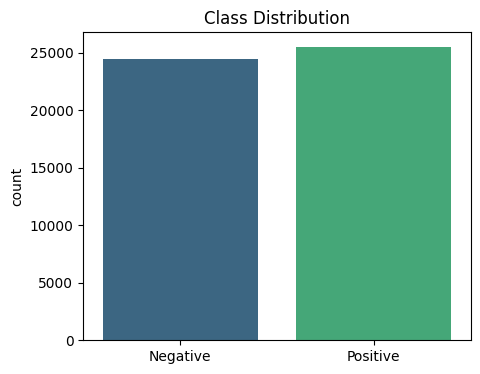

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x=labels, palette="viridis")
plt.title("Class Distribution")
plt.xticks([0,1], ["Negative","Positive"])
plt.show()

In [9]:
neg_text = " ".join([texts[i] for i in range(len(labels)) if labels[i]==0])
pos_text = " ".join([texts[i] for i in range(len(labels)) if labels[i]==1])

# Negative review visualization

Text(0.5, 1.0, 'Negative Reviews')

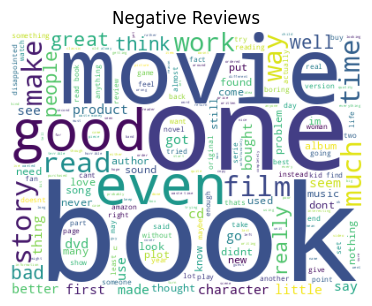

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
WordCloud(width=400, height=300, background_color="white").generate(neg_text)
plt.imshow(WordCloud(width=400, height=300, background_color="white").generate(neg_text))
plt.axis("off")
plt.title("Negative Reviews")

# Positive review Visualization

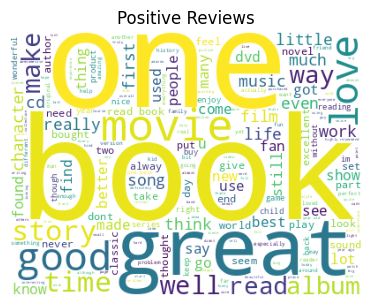

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color="white").generate(pos_text))
plt.axis("off")
plt.title("Positive Reviews")
plt.show()

# Train-Test-Split (stratified)

In [12]:
X_train, X_test, y_train, y_test, titles_train, titles_test = train_test_split(
    texts, labels, titles, test_size=0.2, random_state=42, stratify=labels
)

# **Optimized TF-IDF + LinearSVC Pipeline**

In [13]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('clf', LinearSVC())
])

Train Model and Prediction

In [14]:
# Train model
pipeline.fit(X_train, y_train)

# Predict class labels
y_pred = pipeline.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8568


In [16]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, labels=[0, 1], target_names=["Negative", "Positive"]))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      4899
    Positive       0.86      0.86      0.86      5101

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# Confusion Matrix

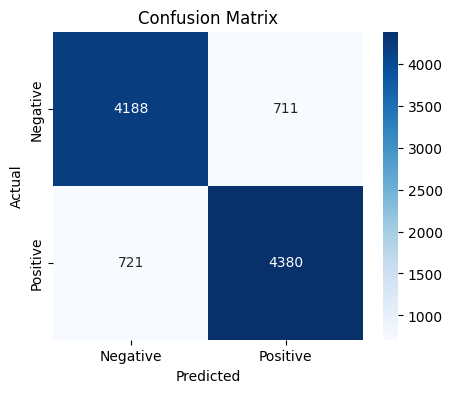

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Extract Top Features for Visualization

In [18]:
# Extract feature names and coefficients from pipeline
vectorizer = pipeline.named_steps['tfidf']
model = pipeline.named_steps['clf']
feature_names = vectorizer.get_feature_names_out()
coef = model.coef_[0]

In [19]:
top_pos_idx = coef.argsort()[-20:]
top_neg_idx = coef.argsort()[:20]

# ***Top Positive Words***

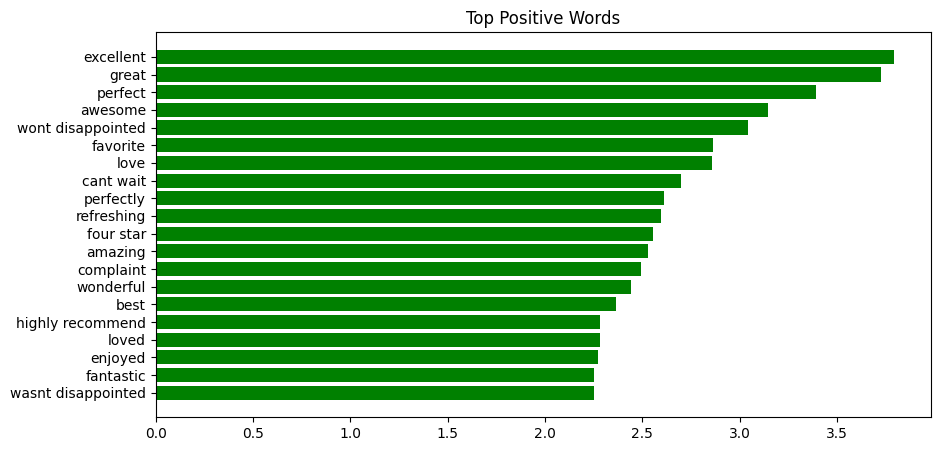

In [20]:
plt.figure(figsize=(10,5))
plt.barh(feature_names[top_pos_idx], coef[top_pos_idx], color="green")
plt.title("Top Positive Words")
plt.show()

# ***Top Negative Words***

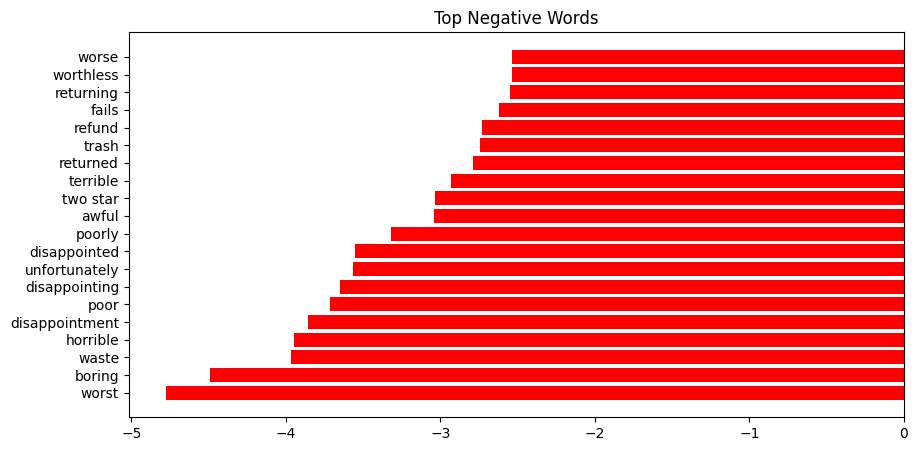

In [21]:
plt.figure(figsize=(10,5))
plt.barh(feature_names[top_neg_idx], coef[top_neg_idx], color="red")
plt.title("Top Negative Words")
plt.show()

# **Test**

In [22]:
# Include titles in the split to fix 'titles_test' issue
X_train, X_test, y_train, y_test, titles_train, titles_test = train_test_split(
    texts, labels, titles, test_size=0.2, random_state=42, stratify=labels
)

In [23]:
# Refit pipeline because we re-split data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [24]:
for i in range(5):
    product = titles_test[i]
    review = X_test[i]
    sentiment = "Positive" if y_pred[i] == 1 else "Negative"
    recommendation = "✅ Worth buying!" if y_pred[i] == 1 else "❌ Needs improvement."

    print(f"\nProduct: {product}")
    print(f"Review: {review[:100]}...")
    print(f"Sentiment: {sentiment}")
    print(f"Recommendation: {recommendation}")


Product: the complete king
Review: wonderful compilation elvis work early final yearsnote advance recording technology career...
Sentiment: Positive
Recommendation: ✅ Worth buying!

Product: Not bad, and essential...
Review: firsthand tale night exactly frittered away mindless hostility toward russia might warmer relation p...
Sentiment: Negative
Recommendation: ❌ Needs improvement.

Product: 1 star is being very generous
Review: movie joan arc worst representation life ever produced history accurate joans mission totally missed...
Sentiment: Negative
Recommendation: ❌ Needs improvement.

Product: Attitude
Review: first got book thought would good read especially escapade cooking liked little tidbit julia child h...
Sentiment: Negative
Recommendation: ❌ Needs improvement.

Product: great purchase
Review: great book great presentation first time bought something kindle really please far looking forward n...
Sentiment: Positive
Recommendation: ✅ Worth buying!


# Prepare Vectors for KNN & Random Forest

In [25]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# **KNN Classifier**

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)
y_pred_knn = knn.predict(X_test_vec)

In [28]:
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.6839


# **Random Forest Algorithm**

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)

In [31]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.83


# **GridSearch for LinearSVC**

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
param_grid = {
    'clf__C': [0.1, 1, 2, 5],
    'clf__loss': ['hinge', 'squared_hinge']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=20000,
                                                        ngram_range=(1, 2))),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 2, 5],
                         'clf__loss': ['hinge', 'squared_hinge']},
             verbose=1)

In [34]:
print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Params: {'clf__C': 0.1, 'clf__loss': 'squared_hinge'}
Best CV Accuracy: 0.8576500223215046


In [35]:
import pandas as pd

# Compare Prediction

In [36]:
# Create a DataFrame to compare actual and predicted labels for the test set
results_df = pd.DataFrame({
    'Review': X_test,  # original review text from the test set
    'Actual': y_test,
    'Predicted_LR': y_pred,
    'Predicted_KNN': y_pred_knn,
    'Predicted_RF': y_pred_rf
})
results_df.head()

,Review,Actual,Predicted_LR,Predicted_KNN,Predicted_RF
0,wonderful compilation elvis work early final y...,1,1,0,1
1,firsthand tale night exactly frittered away mi...,1,0,1,1
2,movie joan arc worst representation life ever ...,0,0,0,0
3,first got book thought would good read especia...,0,0,0,0
4,great book great presentation first time bough...,1,1,1,1


# **Hyperparameter Tuning**

**For Logistic Regression**

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [38]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

In [39]:
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
             scoring='accuracy')

In [40]:
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)

Best Logistic Regression Params: {'C': 1, 'penalty': 'l2'}


**For KNN**

In [41]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

In [42]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [43]:
best_knn = grid_knn.best_estimator_
print("Best KNN Params:", grid_knn.best_params_)

Best KNN Params: {'n_neighbors': 7, 'weights': 'distance'}


In [44]:
best_knn

KNeighborsClassifier(n_neighbors=7, weights='distance')

**For Random Forest**

In [45]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

In [46]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [47]:
best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


# **Evaluate Tuned Models**

In [48]:
y_pred_best_lr = best_lr.predict(X_test_vec)
y_pred_best_knn = best_knn.predict(X_test_vec)
y_pred_best_rf = best_rf.predict(X_test_vec)

In [49]:
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best_lr))
print("Tuned KNN Accuracy:", accuracy_score(y_test, y_pred_best_knn))
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))

Tuned Logistic Regression Accuracy: 0.8651
Tuned KNN Accuracy: 0.7054
Tuned Random Forest Accuracy: 0.8337


In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

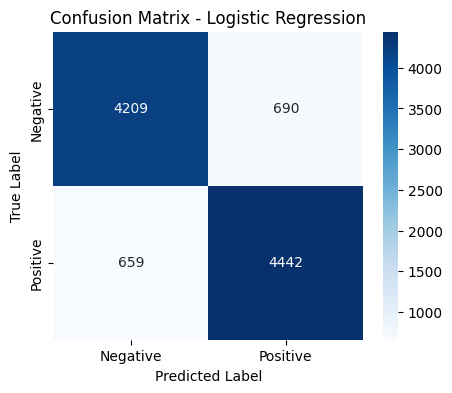

=== Logistic Regression ===
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      4899
    Positive       0.87      0.87      0.87      5101

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [52]:
# Logistic Regression
plot_conf_matrix(y_test, y_pred_best_lr, "Logistic Regression")

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_best_lr, target_names=['Negative', 'Positive']))

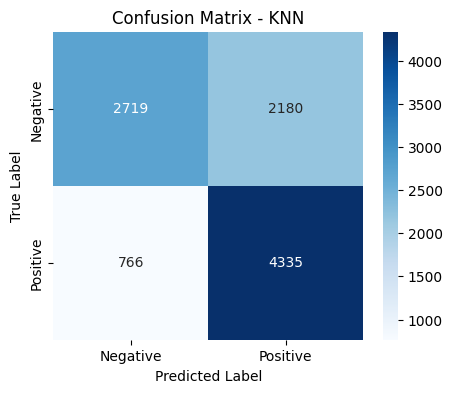

=== KNN ===
              precision    recall  f1-score   support

    Negative       0.78      0.56      0.65      4899
    Positive       0.67      0.85      0.75      5101

    accuracy                           0.71     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.71      0.70     10000



In [53]:
# KNN
plot_conf_matrix(y_test, y_pred_best_knn, "KNN")

print("=== KNN ===")
print(classification_report(y_test, y_pred_best_knn, target_names=['Negative', 'Positive']))

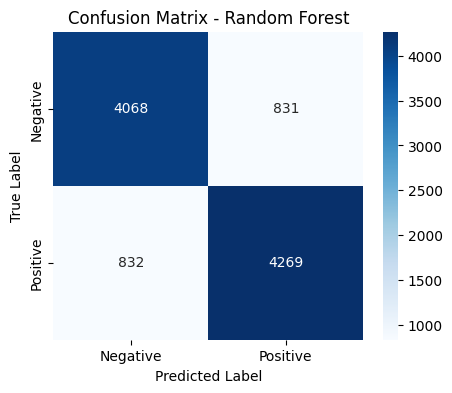

=== Random Forest ===
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83      4899
    Positive       0.84      0.84      0.84      5101

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [54]:
# Random Forest
plot_conf_matrix(y_test, y_pred_best_rf, "Random Forest")

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_best_rf, target_names=['Negative', 'Positive']))

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [56]:
# Calculate metrics for each tuned model
metrics_data = {
    'Model': ['Logistic Regression', 'KNN', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_best_lr),
        accuracy_score(y_test, y_pred_best_knn),
        accuracy_score(y_test, y_pred_best_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_best_lr, average='weighted'),
        precision_score(y_test, y_pred_best_knn, average='weighted'),
        precision_score(y_test, y_pred_best_rf, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_best_lr, average='weighted'),
        recall_score(y_test, y_pred_best_knn, average='weighted'),
        recall_score(y_test, y_pred_best_rf, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_best_lr, average='weighted'),
        f1_score(y_test, y_pred_best_knn, average='weighted'),
        f1_score(y_test, y_pred_best_rf, average='weighted')
    ]
}

In [57]:
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.8651   0.865097  0.8651  0.865090
1                  KNN    0.7054   0.721635  0.7054  0.698488
2        Random Forest    0.8337   0.833701  0.8337  0.833700


# **ROC-AUC for LinearSVC**

In [58]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [59]:
# Calibrate SVC to get probabilities
calibrated_svc = CalibratedClassifierCV(pipeline.named_steps['clf'], cv=3)
calibrated_svc.fit(X_train_vec, y_train)
y_scores_svc = calibrated_svc.predict_proba(X_test_vec)[:,1]

In [60]:
fpr, tpr, _ = roc_curve(y_test, y_scores_svc)
roc_auc = auc(fpr, tpr)

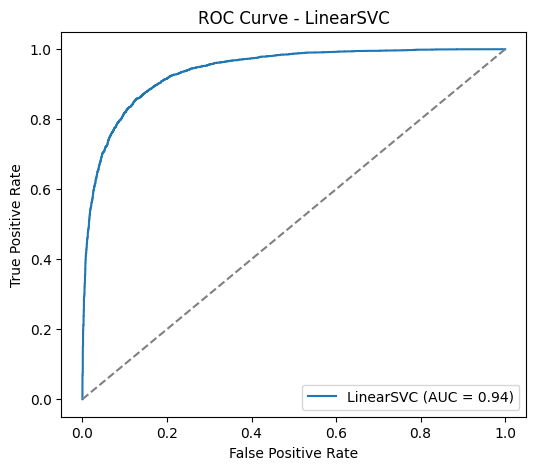

In [61]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LinearSVC")
plt.legend()
plt.show()

# **Precision-Recall Curve for LinearSVC**

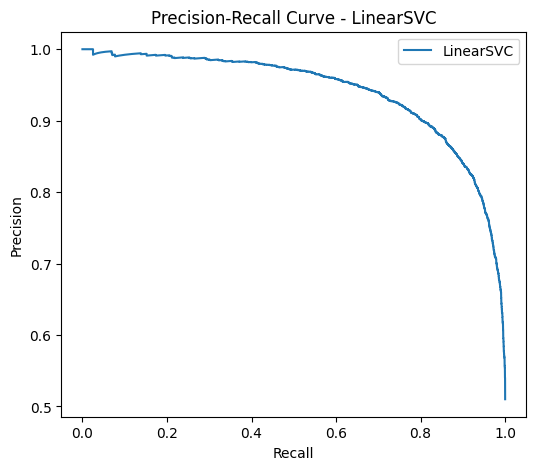

In [62]:
precision, recall, _ = precision_recall_curve(y_test, y_scores_svc)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='LinearSVC')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LinearSVC")
plt.legend()
plt.show()

# **ROC-AUC for Random Forest**

In [63]:
y_scores_rf = best_rf.predict_proba(X_test_vec)[:,1]

In [64]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

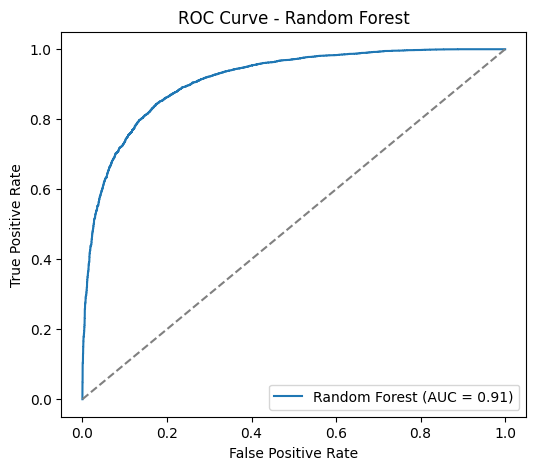

In [65]:
plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# **Precision-Recall Curve for Random Forest**

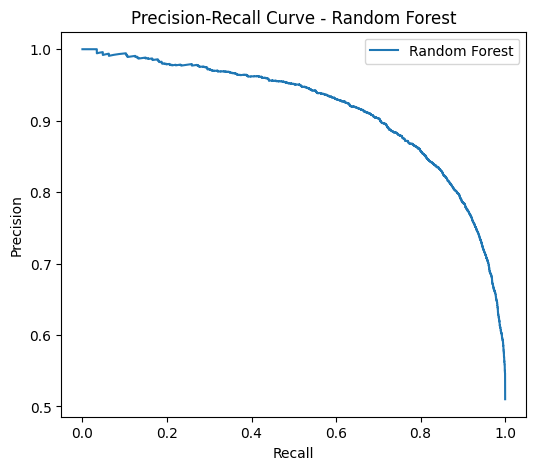

In [66]:
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)

plt.figure(figsize=(6,5))
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.show()